# Umělé neuronové sítě typu MLP


## Data

In [98]:
import numpy as np
import matplotlib.pyplot as plt

def show_loss(iterations, loss, epoch=False):
    plt.plot(iterations, loss)
    plt.xlabel("Epocha" if epoch else "Iterace")
    plt.ylabel("Loss")
    plt.title("Průběh trénování")
    plt.show()

npzfile = np.load('data/data_10.npz')
npzfile.files


['x', 'xTest', 'y', 'yTest', 'w1', 'w2']

In [99]:
x = npzfile['x']
xTest = npzfile['xTest']

y = npzfile['y']
yTest = npzfile['yTest']

print(f"{x.shape=}")
print(f"{y.shape=}")
print(f"Počet tříd: {np.max(y) + 1}")

w1test = npzfile['w1']
w2test = npzfile['w2']

x.shape=(4500, 400)
y.shape=(4500, 1)
Počet tříd: 10


## Stavební bloky sítě

### Funkce sigmoid

$$ sigmoid(u) = \sigma (u) = \frac{e^u}{1+e^u} = \frac{1}{1+e^{-u}} $$


In [100]:
def sigmoid(u):
    #################################################################
    # SIGMOID AKTIVAČNÍ FUNKCE
    #
    # Co je to sigmoid?
    # - Sigmoid je nelineární funkce, která "zmáčkne" jakoukoliv hodnotu do rozmezí (0, 1)
    # - Pro velké kladné hodnoty dává výstup blízko 1
    # - Pro velké záporné hodnoty dává výstup blízko 0
    # - Pro hodnotu 0 dává výstup přesně 0.5
    #
    # Proč používáme sigmoid?
    # - Přidává nelinearitu do neuronové sítě (bez nelinearity by celá síť byla jen lineární transformace)
    # - Výstup lze interpretovat jako "pravděpodobnost aktivace" neuronu
    # - Hladká a diferencovatelná (důležité pro backpropagation)
    #
    # Matematický vzorec: sigmoid(u) = 1 / (1 + e^(-u))
    #
    # Numerická stabilita:
    # - Pro velmi záporné u by e^(-u) mohlo způsobit přetečení
    # - Používáme bezpečnější verzi vzorce
    return 1.0 / (1.0 + np.exp(-u))
    #################################################################


In [101]:
#Kontrola:
u = np.array([[1,2],[-3,-4]])
sigmoid(u)

array([[0.73105858, 0.88079708],
       [0.04742587, 0.01798621]])

#### Derivace funkce sigmoid:
$$ \sigma' (u) = \sigma (u) (1 - \sigma(u)) $$

In [102]:
def sigmoid_grad(u):
    
    #################################################################
    # DERIVACE SIGMOID FUNKCE
    #
    # Co je derivace a proč ji potřebujeme?
    # - Derivace říká, jak rychle se funkce mění v daném bodě
    # - Během backpropagation potřebujeme derivace, abychom věděli, jak moc upravit váhy
    # - Derivace sigmoid funkce má elegantní tvar: σ'(u) = σ(u) * (1 - σ(u))
    #
    # Intuice:
    # - Na okrajích (u blízko -∞ nebo +∞) je derivace malá → sigmoid je tam "plochá"
    # - Uprostřed (u blízko 0) je derivace největší → sigmoid se tam mění nejrychleji
    # - Maximum derivace je 0.25 v bodě u=0
    #
    # Problém "vanishing gradient":
    # - Pro velké |u| je derivace blízko 0
    # - To zpomaluje učení, když máme hodně vrstev
    # - Proto se dnes často používá ReLU místo sigmoid

    sig = sigmoid(u)
    return sig * (1.0 - sig)
    #################################################################


In [103]:
#Kontrola:
sigmoid_grad(u)

array([[0.19661193, 0.10499359],
       [0.04517666, 0.01766271]])

### ReLU

$$ f(u) = max(0, u) $$



In [104]:
def relu(u):
    #################################################################
    # ReLU AKTIVAČNÍ FUNKCE (Rectified Linear Unit)
    #
    # Co je ReLU?
    # - Velmi jednoduchá funkce: vrátí hodnotu, pokud je kladná, jinak vrátí 0
    # - Matematicky: f(u) = max(0, u)
    #
    # Proč je ReLU tak populární?
    # - Jednoduchost: rychlé výpočty (jen porovnání s nulou)
    # - Netrpí "vanishing gradient" problémem (derivace je buď 0 nebo 1)
    # - Empiricky funguje velmi dobře v hlubokých sítích
    # - Biologicky inspirováno (neurony buď "pálí" nebo ne)
    #
    # Výhody oproti sigmoid:
    # - Rychlejší učení (gradient není nikdy menší než 1 pro kladné hodnoty)
    # - Řídká aktivace (hodně neuronů může být "vypnutých" = 0)
    # - Jednodušší gradient (není třeba počítat exponenciály)
    #
    # Nevýhody:
    # - "Dying ReLU" problém: neuron se může "zabít" (vždy vrací 0)
    # - Není hladká v bodě 0 (ale v praxi to nevadí)
    return np.maximum(0, u)
    #################################################################


In [105]:
#Kontrola:
relu(u)

array([[1, 2],
       [0, 0]])

#### Derivace funkce ReLU:
$$ f'(x) = \boldsymbol{1} (x \ge 0)$$

Derivace přímo v bodě nula je dodefinována na hodnotu nula.

Gradient se přes tento blok přenáší:
1) Nezměněný, pokud je hodnota na vstupu z dopředného průchodu větší než nula.
2) Přenesená hodnota je nula, pokud je hodnota na vstupu z dopředného průchodu menší nebo rovna nule.

In [106]:
def relu_grad(u):
    #################################################################
    # DERIVACE ReLU FUNKCE
    #
    # Matematická definice:
    # - f'(u) = 1, pokud u > 0
    # - f'(u) = 0, pokud u ≤ 0
    # - (V bodě 0 není derivace definována, ale dodefinujeme ji na 0)
    #
    # Co to znamená pro backpropagation?
    # - Pokud byl neuron aktivní (u > 0), gradient projde beze změny
    # - Pokud byl neuron neaktivní (u ≤ 0), gradient se zablokuje (= 0)
    # - Toto je jako "přepínač" - buď pustí gradient dál, nebo ho zastaví
    #
    # Implementace:
    # - Stačí zjistit, kde je u > 0
    # - NumPy vrátí boolean array, který můžeme použít při násobení
    # - True se chová jako 1, False jako 0

    return u > 0  #returns bol array
    #################################################################


In [107]:
#Kontrola:
relu_grad(u)

array([[ True,  True],
       [False, False]])

### One Hot Encoding
$ \pi $ nabývá hodnoty 1 pouze pro jednu třídu. Např. máme celkem 3 třídy (0, 1, 2): $\pi_0 = [0,1,0]$  pro $y_0 = 1$


$$
    classes = 
        \begin{bmatrix}
        1 \\
        0 \\
        2\\
        1 \\
        \end{bmatrix} 
    \implies
        \pi = 
        \begin{bmatrix}
        0 & 1 & 0 \\
        1 & 0 & 0 \\
        0 & 0 & 1 \\
        0 & 1 & 0 \\
        \end{bmatrix} 
$$

In [108]:
def one_hot_encoding(data):
    #################################################################
    # ONE-HOT ENCODING (Jednotková reprezentace)
    #
    # Co je one-hot encoding?
    # - Převádí čísla tříd (0, 1, 2, ...) na vektory s jednou 1 a ostatními 0
    # - Příklad pro 3 třídy:
    #   třída 0 → [1, 0, 0]
    #   třída 1 → [0, 1, 0]
    #   třída 2 → [0, 0, 1]
    #
    # Proč to potřebujeme?
    # - Neuronová síť dává výstup jako vektor pravděpodobností pro každou třídu
    # - Potřebujeme cílové hodnoty ve stejném formátu pro výpočet chyby (loss)
    # - One-hot vektor říká "tady má být 1, jinde 0"
    #
    # Jak vypočítat loss?
    # - Cross-entropy loss: -sum(y_true * log(y_pred))
    # - Díky one-hot kódování se sečte jen log pravděpodobnosti správné třídy
    #
    # Implementace:
    # 1. Zjistíme počet vzorků a počet tříd
    # 2. Vytvoříme matici nul (n_samples × n_classes)
    # 3. Na správná místa dáme jedničky pomocí indexování
    #################################################################

    # Flatten data pro případ, že je 2D (N, 1) místo (N,)
    data = data.flatten()

    # Počet vzorků a tříd
    n_samples = len(data)
    n_classes = np.max(data) + 1  # +1 protože třídy začínají od 0

    # Vytvoříme matici nul
    # Rozměr: (počet vzorků) × (počet tříd)
    encoded = np.zeros((n_samples, n_classes))

    # Pro každý vzorek nastavíme 1 na index odpovídající jeho třídě
    # np.arange(n_samples) = [0, 1, 2, ..., n_samples-1] (řádky)
    # data = [třída_0, třída_1, třída_2, ...] (sloupce)
    # encoded[i, data[i]] = 1 pro všechny i najednou
    encoded[np.arange(n_samples), data] = 1

    return encoded


In [109]:
#Kontrola:
encoded = one_hot_encoding(y)
encoded[[0,900,1800,2700,3500,4200],:]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

### Softmax

- Funkce softmax má c vstupů a c výstupů. 
- Všechny výstupy jsou kladná čísla. 
- Součet všech výstupů dohromady je roven číslu 1.
$$\widehat{y_c} = softmax(u) = \frac{e^{u_c}}{\sum_{d=0}^{c} {e^{u_d}}} $$


In [110]:
def softmax(u):
    """
    softmax !radkove!
    """
    #################################################################
    # SOFTMAX FUNKCE
    #
    # Co je softmax?
    # - Převádí vektor libovolných čísel na vektor pravděpodobností
    # - Všechny výstupy jsou v rozmezí (0, 1) a jejich součet je 1
    # - Vzorec: softmax(u_i) = e^(u_i) / sum(e^(u_j) pro všechna j)
    #
    # Proč používáme softmax?
    # - Na výstupu klasifikační sítě chceme pravděpodobnosti tříd
    # - Vyšší vstupní hodnota → vyšší pravděpodobnost
    # - Exponenciála zajistí, že velké rozdíly ve vstupu se výrazně projeví
    #
    # Důležité: Tato implementace je ŘÁDKOVÁ (row-wise)
    # - Každý řádek matice je jeden vzorek
    # - Softmax se aplikuje na každý řádek zvlášť
    # - Součet pravděpodobností v každém řádku je 1
    #
    # Numerická stabilita:
    # - e^(velké číslo) může přetéct
    # - Odečteme maximum z každého řádku: softmax(u - max(u)) = softmax(u)
    # - To nevymění výsledek, ale zabrání přetečení
    #
    # Dimenze:
    # - Vstup u: (n_samples, n_classes)
    # - Výstup: (n_samples, n_classes)
    # - axis=1 znamená "po řádcích" (pro každý vzorek zvlášť)

    # Odečteme maximum z každého řádku pro numerickou stabilitu
    # keepdims=True zajistí, že výsledek má stále 2D tvar pro broadcasting
    u_shifted = u - np.max(u, axis=1, keepdims=True)

    # Exponenciála pro všechny prvky
    exp_u = np.exp(u_shifted)

    # Vydělíme součtem v každém řádku
    # axis=1 = po řádcích (každý vzorek zvlášť)
    return exp_u / np.sum(exp_u, axis=1, keepdims=True)
    #################################################################

In [111]:
#Kontrola:
softmax(u)

array([[0.26894142, 0.73105858],
       [0.73105858, 0.26894142]])

In [112]:
def theta_grad(grad_on_output, input_data):
    #################################################################
    #shape: (n_neurons, n_samples) @ (n_samples, n_inputs) = (n_neurons, n_inputs)
    weight_grad = grad_on_output.T @ input_data

    #gradient biasu: suma gradientu přes všechny vzorky (axis=0)
    #shape: (n_samples, n_neurons) → suma přes vzorky → (n_neurons,)
    bias_grad = np.sum(grad_on_output, axis=0)
    #################################################################
    return weight_grad, bias_grad

In [113]:
#test vypoctu gradientu pro matici vah a biasy

#dva vstupni vektory, kazdy ma 4 hodnoty, cili jde o vrstvu, kde kazdy neuron ma 4 vstupy
input_test = np.array([[7,8,4,1],[9,10,4,2]])
print("input_test")
print(input_test.shape)

#dva gradienty na vystupu, kazdy ma 3 hodnoty, cili jde o vrstvu, ktera ma 3 neurony [a kazdy ma 4 vstupy])
grad_on_output_test = np.array([[1,2,3],[4,2,6]])
print("grad_on_output_test")
print(grad_on_output_test.shape)

w_grad_test,u_grad_test = theta_grad(grad_on_output_test,input_test)

#gradienu vektoru vah ma tedy rozmery 3*4
print("w_grad_test")
print(w_grad_test.shape)
print(w_grad_test)

#gradient biasu ma 3 hodnoty
print("u_grad")
print(u_grad_test.shape)
print(u_grad_test)

input_test
(2, 4)
grad_on_output_test
(2, 3)
w_grad_test
(3, 4)
[[43 48 20  9]
 [32 36 16  6]
 [75 84 36 15]]
u_grad
(3,)
[5 4 9]


## Sítě typu vícevrstvý perceptron = Multi-Layer Perceptron (MLP)



### Předzpracování dat
Pro trénování neuronových sítí je vhodné provádět standardizaci dat na nulovou střední hodnotu a jednotkový rozptyl.

### Inicializace parametrů (váhových koeficientů)
- Váhy neuronů nesmí být nastaveny na stejné hodnoty (např. 0), aby neměly stejnou hodnotu výstupu a stejný gradient
=>
- Je třeba porušit symetrii:
    - Váhy se inicializují jako malá náhodná čísla (polovina kladná, polovina záporná)
    - V praxi se pro ReLU používá hodnota $randn(n) * sqrt(2.0/n)$, kde n je počet vstupů neuronu
    - Započítání počtu vstupů pak zajišťuje, že neurony s různým počtem vstupů mají výstup se stejným rozptylem hodnot
    - Biasy se inicializují na hodnotu 0 nebo 0.01 (symetrie je již porušena inicializací váhových koeficientů)

### Dopředný průchod
Kroky:
1. $x_1$ je $x$ rozšířená o sloupec bias
2. $u_1 = \theta_1^T x_1$ (vstupní vrstva)
3. $a_1 = ReLU(u_1)$ (aktivační funkce, v kódu použijte obecně `activation_function`)
4. $x_2$ je $a_1$ rozšířená o sloupec bias
5. $u_2 = \theta_2^T x_2$ (skrytá vrstva)
6. $\tilde{y} = softmax(u_2)$ (výstupní vrstva)

Na výstupu vznikne podle zvoleného kritéria chyba či odchylka.

### Zpětný průchod

(Hodnoty z dopředného průhodu $x$, $a_1$ a $u_2$ je vhodné si z dopředného průchodu uložit.)

1. $du_2 = softmax(u_2)-\pi(y)$

2. $dW_2 = du_2 a_1^T$  a  $db_2 = du_2 $

3. $da_1 = W_2^T du_2$

4. $du_1 = da_1 \odot relu'(du_1)$ (v kódu použijte obecně `activation_function_derivation`)

5. $dW_1 = du_1^T x$  a  $db = du_1 $

In [114]:
class TwoLayerPerceptron:
    def __init__ (self, *, input_layer_size, hidden_layer_size, output_size, activation_function, activation_function_derivation):
        #################################################################
        # VRSTVA 1: vstup (400) → skrytá vrstva (25 neuronů)
        # Inicializujeme váhy náhodnými čísly
        # Shape: (25, 401) kde 401 = 400 vstupů + 1 bias
        # Použijeme He initialization: randn * sqrt(2.0 / počet_vstupů)
        self.w1 = np.random.randn(hidden_layer_size, input_layer_size + 1) * np.sqrt(2.0 / input_layer_size)

        # VRSTVA 2: skrytá vrstva (25) → výstup (10 tříd)
        # Shape: (10, 26) kde 26 = 25 vstupů ze skryté vrstvy + 1 bias
        self.w2 = np.random.randn(output_size, hidden_layer_size + 1) * np.sqrt(2.0 / hidden_layer_size)

        #activation fun cache
        self.activation_function = activation_function
        self.activation_function_derivation = activation_function_derivation

        #################################################################
        
    def forward(self, x) -> tuple[np.ndarray, dict]:
        """
        Spočítá predikci na základě aktuálních vah.
        """

        #################################################################
        #
        #1. vrstva

        x1 = np.c_[np.ones(x.shape[0]), x]  # np.c_ = column stack (spojí sloupce)
        u1 = x1 @ self.w1.T

        #aktivacni funkce pomocí funkce self.activation_function
        a1 = self.activation_function(u1)

        #2. vrstva (skryta vrstva)
        x2 = np.c_[np.ones(a1.shape[0]), a1]
        u2 = x2 @ self.w2.T

        #vystup po softmaxu
        scores = softmax(u2) #4500x10 scores pro kazdou tridu

        forward_cache = {
            'x1': x1,  # Vstup do první vrstvy (s biasem)
            'u1': u1,  # Hodnoty PŘED aktivační funkcí (první vrstva)
            'a1': a1,  # Aktivace první vrstvy (výstup po ReLU/sigmoid)
            'x2': x2,  # Vstup do druhé vrstvy (s biasem)
            'u2': u2   # Hodnoty před softmaxem (druhá vrstva)
        }

        #################################################################
        
        # forward_cache je dictionary obsahující uložené hodnoty potřebné pro zpětný průchod
        return scores, forward_cache
    
    def backward(self, classes, forward_cache: dict) -> dict:
        """
        Vypočítá gradienty na základě hodnot uložených při dopředném průchodu.
        """

        #################################################################
        # Získáme uložené hodnoty z dopředného průchodu
        x1 = forward_cache['x1']  # Vstup do 1. vrstvy (s biasem)
        u1 = forward_cache['u1']  # Před aktivací 1. vrstvy
        a1 = forward_cache['a1']  # Po aktivaci 1. vrstvy
        x2 = forward_cache['x2']  # Vstup do 2. vrstvy (s biasem)

        scores = softmax(forward_cache['u2'])
        y_one_hot = one_hot_encoding(classes)

        #pomocí self.scores, self.classes a one_hot_encoding
        du2 = scores - y_one_hot

        #pomocí funkce theta_grad
        # Předáme JEN aktivace a1 (bez biasu) = x2[:, 1:]
        dw2, db2 = theta_grad(du2, x2[:, 1:])

        da1 = du2 @ self.w2[:, 1:]  # Vynecháme první sloupec (bias)

        activation_grad = self.activation_function_derivation(u1)

        #pomocí funkce self.activation_function_derivation
        #POZOR: tato funce se musí aplikovat na vstupní hodnotu z dopředného průchodu !!
        # Element-wise násobení: kde byl neuron aktivní, gradient projde
        #                        kde byl neaktivní, gradient se zablokuje
        du1 = da1 * activation_grad

        # Předáme JEN vstupní data (bez biasu) = x1[:, 1:]
        #pomocí funkce theta_grad
        dw1, db1 = theta_grad(du1, x1[:, 1:])

        gradients = {
            'dw1': dw1,  # Gradient vah první vrstvy
            'db1': db1,  # Gradient biasů první vrstvy
            'dw2': dw2,  # Gradient vah druhé vrstvy
            'db2': db2   # Gradient biasů druhé vrstvy
        }
        #################################################################

        # gradients je dictionary obsahující vypočtené gradienty
        return gradients


    def update_weights_gd(self, gradients: dict, alpha, lmbd=0):
        """
        Aktualizuje váhy sítě na základě vypočtených gradientů.
        """

        #################################################################

        # Extrahujeme gradienty z dictionary
        dw1 = gradients['dw1']  # Shape: (25, 400)
        db1 = gradients['db1']  # Shape: (25,)
        dw2 = gradients['dw2']  # Shape: (10, 25)
        db2 = gradients['db2']  # Shape: (10,)

        full_grad_w1 = np.c_[db1[:, np.newaxis], dw1]

        regularization_w1 = np.c_[np.zeros((self.w1.shape[0], 1)), lmbd * self.w1[:, 1:]]

        # Aktualizace: w1_new = w1_old - alpha * (gradient + regularizace)
        # Shape: (25, 401) = (25, 401) - learning_rate * ((25, 401) + (25, 401))
        self.w1 = self.w1 - alpha * (full_grad_w1 + regularization_w1)

        full_grad_w2 = np.c_[db2[:, np.newaxis], dw2]

        regularization_w2 = np.c_[np.zeros((self.w2.shape[0], 1)), lmbd * self.w2[:, 1:]]
        self.w2 = self.w2 - alpha * (full_grad_w2 + regularization_w2)


    def accuracy(self, x, classes):
        #################################################################
        scores, _ = self.forward(x)  # _ = ignorujeme cache, nepotřebujeme ho

        # argmax(axis=1) najde index maximální hodnoty v každém řádku
        # To je predikovaná třída pro každý vzorek
        # Shape: (n_samples,)
        predicted_classes = np.argmax(scores, axis=1)

        # Porovnáme predikce s pravdivými třídami
        # classes.flatten() zajistí shape (n_samples,) místo (n_samples, 1)
        # predicted_classes == classes.flatten() → boolean array [True, False, True, ...]
        # np.mean() spočítá průměr: True=1, False=0 → procento správných
        accuracy = np.mean(predicted_classes == classes.flatten())

        return accuracy
        #################################################################
            


In [115]:
input_layer_size = 400
hidden_layer_size = 25
output_size = len(np.unique(y))


In [116]:
#Instance pro odladění:
testTlp = TwoLayerPerceptron(input_layer_size=input_layer_size, hidden_layer_size=hidden_layer_size, output_size=output_size, activation_function=sigmoid, activation_function_derivation=sigmoid_grad)
testTlp.w1 = w1test
testTlp.w2 = w2test
# alpha = 0.0005, lmbd=0

...

Ellipsis

Data pro odladění s předchozí instancí po jednom kroku trénování:

In [117]:
def train_gd(model, x, classes, nIter, alpha=0.00015, lmbd=0):
    """
    Natrénuje síť a vykreslí graf vývoje lossu.
    """

    # Na konci každé iterace vypočtěte cross-entropy loss a ulože ho na odpovídající index v poli.
    loss = np.zeros(nIter)

    #################################################################

    # One-hot enkódujeme třídy jednou před smyčkou (efektivnější)
    y_one_hot = one_hot_encoding(classes)

    # Hlavní trénovací smyčka
    for iteration in range(nIter):

        # KROK 1: Dopředný průchod - získáme predikce
        # scores má shape (n_samples, n_classes)
        # Každý řádek = pravděpodobnosti tříd pro jeden vzorek
        scores, forward_cache = model.forward(x)

        # KROK 2: Výpočet Cross-Entropy Loss
        #
        # Vzorec: L = -mean(sum(y_true * log(y_pred)))
        #
        # Rozpiška:
        # 1. log(scores + 1e-15): logaritmus predikovaných pravděpodobností
        #    - +1e-15 zabrání log(0), který by byl -∞
        # 2. y_one_hot * log(...): násobíme s one-hot → zůstanou jen správné třídy
        # 3. np.sum(...): sečteme pro všechny třídy a všechny vzorky
        # 4. - ... / n_samples: průměrná ztráta na vzorek (záporná → kladná)
        #
        # Proč průměr? Aby loss nezávisel na počtu vzorků v batchi
        loss[iteration] = -np.sum(y_one_hot * np.log(scores + 1e-15)) / x.shape[0]

        # KROK 3: Zpětný průchod - vypočteme gradienty
        # Gradienty říkají, jak změnit váhy, aby se zmenšil loss
        gradients = model.backward(classes, forward_cache)

        # KROK 4: Aktualizace vah pomocí gradient descent
        # w_new = w_old - learning_rate * gradient
        # - learning_rate (alpha): velikost kroku
        # - regularizace (lmbd): penalizace velkých vah
        model.update_weights_gd(gradients, alpha, lmbd)

        # Každých 100 iterací vypíšeme progress
        if (iteration + 1) % 100 == 0:
            print(f"Iterace {iteration + 1}/{nIter}, Loss: {loss[iteration]:.4f}")

    #################################################################

    show_loss(np.arange(nIter), loss)

Trénování modelu s aktivační funkcí sigmoid:

Iterace 100/800, Loss: 0.6034
Iterace 200/800, Loss: 0.3901
Iterace 300/800, Loss: 0.3163
Iterace 400/800, Loss: 0.2757
Iterace 500/800, Loss: 0.2481
Iterace 600/800, Loss: 0.2271
Iterace 700/800, Loss: 0.2101
Iterace 800/800, Loss: 0.1956


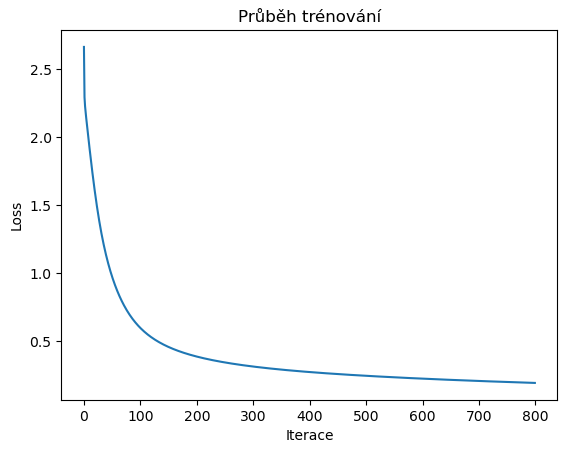

sigmoid testovaci mnozina : 0.908


In [118]:
tlp = TwoLayerPerceptron(input_layer_size=input_layer_size, hidden_layer_size=hidden_layer_size, output_size=output_size, activation_function=sigmoid, activation_function_derivation=sigmoid_grad)
#################################################################
train_gd(tlp, x, y, nIter=800, alpha=0.00015, lmbd=0)
accuracy = tlp.accuracy(xTest, yTest)

#################################################################
print(f"sigmoid testovaci mnozina : {accuracy}") 

Trénování modelu s aktivační funkcí ReLU:

Iterace 100/800, Loss: 0.2523
Iterace 200/800, Loss: 0.1790
Iterace 300/800, Loss: 0.1405
Iterace 400/800, Loss: 0.1133
Iterace 500/800, Loss: 0.0918
Iterace 600/800, Loss: 0.0747
Iterace 700/800, Loss: 0.0614
Iterace 800/800, Loss: 0.0510


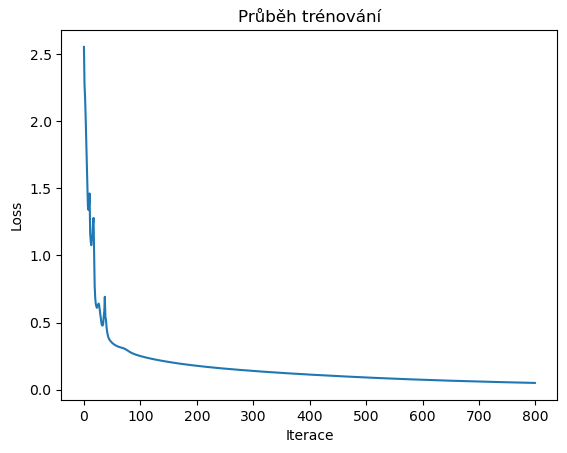

relu testovaci mnozina : 0.922


In [119]:
tlp = TwoLayerPerceptron(input_layer_size=input_layer_size, hidden_layer_size=hidden_layer_size, output_size=output_size, activation_function=relu, activation_function_derivation=relu_grad)
#################################################################
train_gd(tlp, x, y, nIter=800, alpha=0.00015, lmbd=0)
accuracy = tlp.accuracy(xTest, yTest)

#################################################################
print(f"relu testovaci mnozina : {accuracy}")

# Bonus: PyTorch a MNIST

Data: Číslovky z datasetu MNIST z bonusové části 7. cvičení (tam si je můžete prohlédnout).

**Dosáhněte accuracy > 97 %**

Tip: Menší batche napomáhají generalizaci.

In [120]:
import torch
import torch.nn as nn
import torch.optim as optim

In [121]:
npzfile = np.load('data/data_07_mnist_train.npz') 

data = npzfile['data']
ref = npzfile['ref']

# Převod na objekty knihovny PyTorch
data = torch.Tensor(data)
ref = torch.Tensor(ref).long()

In [122]:
npzfile = np.load('data/data_07_mnist_test.npz') 

test_data = npzfile['data']
test_ref = npzfile['ref']

# Převod na objekty knihovny PyTorch
test_data = torch.Tensor(test_data)
test_ref = torch.Tensor(test_ref).long()

In [123]:
# Normalizace hodnot pixelů (na základě statistických odhadů z trénovacích dat)
mean = data.mean()
std = data.std()
data = (data - mean) / std
test_data = (test_data - mean) / std

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
)
Epoch [1/20], Loss: 0.2342
Epoch [2/20], Loss: 0.1125
Epoch [3/20], Loss: 0.0868
Epoch [4/20], Loss: 0.0663
Epoch [5/20], Loss: 0.0590
Epoch [6/20], Loss: 0.0507
Epoch [7/20], Loss: 0.0431
Epoch [8/20], Loss: 0.0429
Epoch [9/20], Loss: 0.0421
Epoch [10/20], Loss: 0.0405
Epoch [11/20], Loss: 0.0370
Epoch [12/20], Loss: 0.0321
Epoch [13/20], Loss: 0.0322
Epoch [14/20], Loss: 0.0315
Epoch [15/20], Loss: 0.0292
Epoch [16/20], Loss: 0.0259
Epoch [17/20], Loss: 0.0289
Epoch [18/20], Loss: 0.0269
Epoch [19/20], Loss: 0.0329
Epoch [20/20], Loss: 0.0335


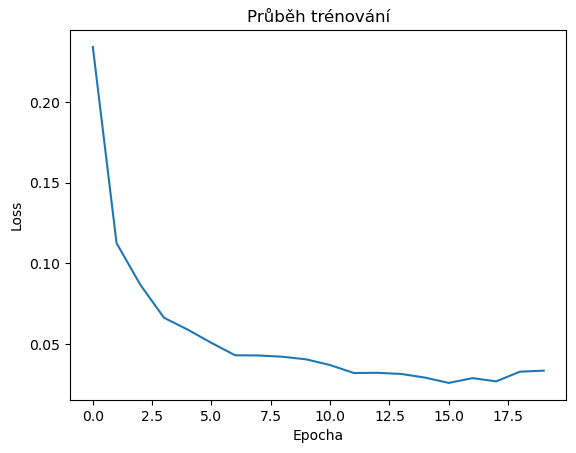

In [124]:
# Definice modelu

#################################################################

input_layer_size = 784  # 28×28 pixelů zploštěných do vektoru
hidden_layer_size = 128  # Experimentujte: 128, 256, nebo i 512
output_size = 10  # 10 tříd (číslice 0-9)

#################################################################

model = nn.Sequential(
    nn.Linear(input_layer_size, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, output_size),
    # SOFTMAX se nepřidává! Kriteriální funkce ho počítá sama. Výstupem sítě jsou tzv. logity.
)

print(model)

# Konfigurace hyperparametrů trénování.
# Optimizér provádí zvolenou metodu optimalizace sítě (SGD / SGD + momentum / ADAM / jiné).
# Parametr weight_decay je lmbd z našeho kódu.
#################################################################

#################################################################

num_epochs = 20  # Kolikrát projdeme všechna trénovací data
batch_size = 64  # Velikost mini-batche (menší = lepší generalizace)

# SGD s momentum
optimizer = optim.SGD(model.parameters(), lr=0.05, weight_decay=0, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0)
#Adam s lepsi regulerizaci
# optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

#################################################################

# Kriteriální funkce: počítá softmax a cross-entropy loss.
# CrossEntropyLoss v PyTorchu ZAHRNUJE softmax!
# Proto model vrací "logits" (před softmaxem), ne pravděpodobnosti
criterion = nn.CrossEntropyLoss()

# Nastaví model do trénovacího módu (důležité pro některé typy vrstev, např. Dropout nebo BatchNorm).
# V našem případě nemá efekt, ale je to dobrý zvyk.
model.train()

losses = np.zeros(num_epochs)
num_batches = data.size(0) // batch_size  # Kolik batchů je v jedné epoše

for epoch in range(num_epochs):
    # Zamíchání dat na začátku každé epochy
    permutation = torch.randperm(data.size(0))
    
    epoch_loss = 0.0

    # Smyčka přes minibatche
    for i in range(0, data.size(0), batch_size):
        indices = permutation[i : i + batch_size]
        batch_x, batch_y = data[indices], ref[indices]

        # PyTorch AKUMULUJE gradienty
        optimizer.zero_grad()

        # Ekvivalent naší funkce forward (bez softmax).
        logits = model(batch_x)

        # Výpočet průměrného lossu podle zvolené kriteriální funkce.
        loss = criterion(logits, batch_y)

        # Spočítá gradienty. Ty nejsou výstupem funkce, ale jsou uloženy u vah, kterých se týkají.
        loss.backward()

        # Aktualizuje váhy podle zvolené metody.
        optimizer.step()
        
        # Přičteme loss z tohoto batche k celkovému lossu epochy
        epoch_loss += loss.item()  # .item() převede torch tensor na Python float

    # Průměrný loss.
    losses[epoch] = epoch_loss / num_batches
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {losses[epoch]:.4f}")

show_loss(np.arange(num_epochs), losses, epoch=True)

In [125]:
# Nastaví model do testovacího módu (důležité pro některé typy vrstev, např. Dropout nebo BatchNorm).
model.eval()

# torch.no_grad() vypne operace pro výpočet gradientu, které se provádí na pozadí, protože je zde nepotřebujeme.
with torch.no_grad():
    logits = model(test_data)
    predicted_classes = logits.argmax(1)
    acc = (predicted_classes == test_ref).float().mean()

print(f"Accuracy: {acc * 100}%")

Accuracy: 97.43000030517578%
